In [1]:
# VSP version of r2_controller GUI
# dew.ninja  May 2024
# run together with Wokwi project : https://wokwi.com/projects/396935752500927489

In [1]:
# class implementation of robo2links controller GUI
import numpy as np
import tkinter as tk
from tkinter import *
from tkinter import ttk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle 
from matplotlib.animation import FuncAnimation
import serial
import time

In [3]:
# Ref: For the following class def, I use code from this link
# https://stackoverflow.com/questions/60413174/rotating-rectangles-around-point-with-matplotlib

In [2]:
class RotatingRectangle(Rectangle):
    def __init__(self, xy, width, height, rel_point_of_rot, **kwargs):
        super().__init__(xy, width, height, **kwargs)
        self.rel_point_of_rot = rel_point_of_rot
        self.xy_center = self.get_xy()
        self.set_angle(self.angle)

    def _apply_rotation(self):
        angle_rad = self.angle * np.pi / 180
        m_trans = np.array([[np.cos(angle_rad), -np.sin(angle_rad)],
                            [np.sin(angle_rad), np.cos(angle_rad)]])
        shift = -m_trans @ self.rel_point_of_rot
        self.set_xy(self.xy_center + shift)

    def set_angle(self, angle):
        self.angle = angle
        self._apply_rotation()

    def set_rel_point_of_rot(self, rel_point_of_rot):
        self.rel_point_of_rot = rel_point_of_rot
        self._apply_rotation()

    def set_xy_center(self, xy):
        self.xy_center = xy
        self._apply_rotation()

Cleaning up.. 


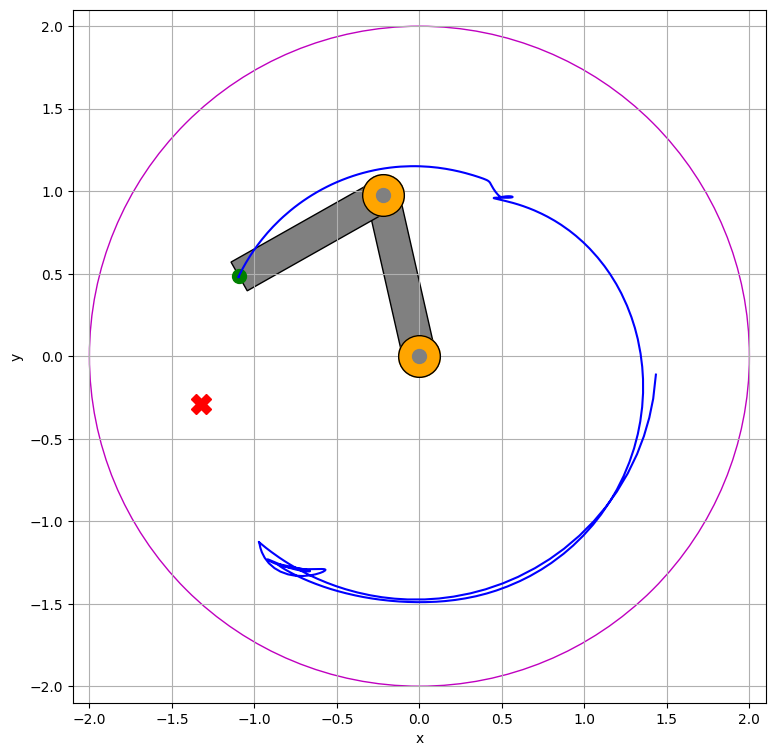

In [5]:

class r2ControllerVSP:

    def __init__(self, root):
        
        screen_width = 1400
        screen_height = 1200
        self.TFont1 = ("Consolas",12)
        self.TFont2 = ("Consolas",14)
        
        self.rad2deg = 180/np.pi
        
        root.title("Robo2links Controller (VSP version)")
        root.protocol("WM_DELETE_WINDOW", self.on_close)
        root.geometry(str(screen_width)+'x'+str(screen_height))
        mainframe = ttk.Frame(root, padding="3 3 12 12")
        mainframe.grid(column=0, row=0, sticky=(N, W, E, S))
        root.columnconfigure(0, weight=1)
        root.rowconfigure(0, weight=1)
        cvrowspan = 15  # canvas row and column span. Increase this from 6 to 14
        cvcolspan = 8  # increase from 3 to 7
        self.vspon = True  # flag whether to use VSP or not

        #---- serial communication setup ------------
        if self.vspon:
            self.ser = serial.Serial('COM8', 115200, timeout=1)
            self.ser.reset_input_buffer() # flush all data that you don't wanna read
            self.ser.reset_output_buffer()
        self.msgline = []
        self.msglines = []        

        
        
        # rectangle size of robot link
        self.link_height = 0.2
        self.link_width = 1        
        # string parameters corresponding to real parmeter values
        self.t_txt = StringVar()
        self.plantsim_txt = StringVar()
        self.datasize_txt = StringVar()
        self.cmdgen_txt = StringVar()
        self.feedback_txt = StringVar()
        self.controller_txt = StringVar()
        self.streaming_txt = StringVar()  # for data streaming mode via VSP
        
        self.iktype_txt = StringVar()  # select ikine method
        self.ikmsg_txt = StringVar()  # message to alert if no solution
        self.ikmsg_txt.set("OK")  
        self.xg_txt = StringVar()   # goal XY coordinate 
        self.yg_txt = StringVar()
        self.xt_txt = StringVar()  # XY coordinate of tool tip
        self.yt_txt = StringVar()
        
        # joint variables, command and actual
        self.q1r_deg_txt = StringVar()
        self.q1_deg_txt = StringVar()
        self.q2r_deg_txt = StringVar()
        self.q2_deg_txt = StringVar()
        self.q1r_txt = StringVar()
        self.qd1r_txt = StringVar()
        self.qdd1r_txt = StringVar()
        self.q2r_txt = StringVar()
        self.qd2r_txt = StringVar()
        self.qdd2r_txt = StringVar()
        self.q1_txt = StringVar()
        self.qd1_txt = StringVar()
        self.qdd1_txt = StringVar()
        self.q2_txt = StringVar()
        self.qd2_txt = StringVar()
        self.qdd2_txt = StringVar()
        self.tau1_txt = StringVar()
        self.tau2_txt = StringVar()
        
        # update parameters to current value
        # ttk.Button(mainframe, text="Update", command=self.dbupdate).grid(column=0, row=cvrowspan+6, sticky=W)
        # command box 
        #  ttk.Label(mainframe, text="Cmd : ", font=self.TFont1).grid(column=0, row=cvrowspan+5, sticky=E)
        # send arbitrary command to Wokwi
        self.r2_txt = StringVar()
        r2cmd_entry = ttk.Entry(mainframe, textvariable=self.r2_txt)
        r2cmd_entry.grid(column=0, row=cvrowspan+5,sticky=(W, E))
        ttk.Button(mainframe, text="Send", command=self.send_r2).grid(column=1, row=cvrowspan+5, sticky=W)

        # joint variable display 
        r2frame = ttk.Frame(mainframe, padding = (2,2,2,2),relief="sunken")
        r2frame.grid(column=0,row=cvrowspan+1)

        # joint variables diaplay --- ref. v.s. actual)
        ttk.Label(r2frame, text="angle (deg)       ", 
                  font=self.TFont1).grid(column=1, row=1, sticky=W)        
        ttk.Label(r2frame, text="angle (rad)       ", 
                  font=self.TFont1).grid(column=2, row=1, sticky=W)
        ttk.Label(r2frame, text="velocity (rad/s)    ", 
                  font=self.TFont1).grid(column=3, row=1, sticky=W)
        ttk.Label(r2frame, text="acceleration (rad/s^2)", 
                  font=self.TFont1).grid(column=4, row=1, sticky=W)
        
        ttk.Label(r2frame, text="J1 (ref.): ",font=self.TFont1).grid(column=0, row=2, sticky=W)
        ttk.Label(r2frame, text="J1 (robot) : ",font=self.TFont1).grid(column=0, row=3, sticky=W)
        ttk.Label(r2frame, text="J2 (ref.) : ",font=self.TFont1).grid(column=0, row=4, sticky=W)
        ttk.Label(r2frame, text="J2 (robot) : ",font=self.TFont1).grid(column=0, row=5, sticky=W)

        # joint variable data from simulation
        #  joint angle (deg) -- ref. v.s. actual
        ttk.Label(r2frame, font=self.TFont1, foreground='blue',
                   textvariable=self.q1r_deg_txt).grid(column=1, row=2, sticky=(W)) 
        ttk.Label(r2frame, font=self.TFont1, foreground='red',
                   textvariable=self.q1_deg_txt).grid(column=1, row=3, sticky=(W)) 
        ttk.Label(r2frame, font=self.TFont1, foreground='blue',
                   textvariable=self.q2r_deg_txt).grid(column=1, row=4, sticky=(W)) 
        ttk.Label(r2frame, font=self.TFont1, foreground='red',
                   textvariable=self.q2_deg_txt).grid(column=1, row=5, sticky=(W)) 
        
        
        #  joint angle (rad) -- ref. v.s. actual
        ttk.Label(r2frame, font=self.TFont1, foreground='brown',
                   textvariable=self.q1r_txt).grid(column=2, row=2, sticky=(W)) 
        ttk.Label(r2frame, font=self.TFont1, foreground='red',
                   textvariable=self.q1_txt).grid(column=2, row=3, sticky=(W)) 
        ttk.Label(r2frame, font=self.TFont1, foreground='brown',
                   textvariable=self.q2r_txt).grid(column=2, row=4, sticky=(W)) 
        ttk.Label(r2frame, font=self.TFont1, foreground='red',
                   textvariable=self.q2_txt).grid(column=2, row=5, sticky=(W)) 
        #  joint velocity -- ref. v.s. actual
        ttk.Label(r2frame, font=self.TFont1, foreground='green',
                   textvariable=self.qd1r_txt).grid(column=3, row=2, sticky=(W)) 
        ttk.Label(r2frame, font=self.TFont1, foreground='red',
                   textvariable=self.qd1_txt).grid(column=3, row=3, sticky=(W)) 
        ttk.Label(r2frame, font=self.TFont1, foreground='green',
                   textvariable=self.qd2r_txt).grid(column=3, row=4, sticky=(W)) 
        ttk.Label(r2frame, font=self.TFont1, foreground='red',
                   textvariable=self.qd2_txt).grid(column=3, row=5, sticky=(W)) 
        #  joint acceleration -- ref. v.s. actual
        ttk.Label(r2frame, font=self.TFont1, foreground='darkgreen',
                   textvariable=self.qdd1r_txt).grid(column=4, row=2, sticky=(W)) 
        ttk.Label(r2frame, font=self.TFont1, foreground='red',
                   textvariable=self.qdd1_txt).grid(column=4, row=3, sticky=(W)) 
        ttk.Label(r2frame, font=self.TFont1, foreground='darkgreen',
                   textvariable=self.qdd2r_txt).grid(column=4, row=4, sticky=(W)) 
        ttk.Label(r2frame, font=self.TFont1, foreground='red',
                   textvariable=self.qdd2_txt).grid(column=4, row=5, sticky=(W)) 
        

       
        #   ------ feedback group.  ------------------------------
        fbframe = ttk.Frame(mainframe, padding = (2,2,2,2),relief="sunken")
        fbframe.grid(column=2, row=0,sticky=(W)) #column=cvcolspan,row=0)        
        # self.feedback_txt.set("1")  
        ttk.Label(fbframe, text="Feedback          ", 
                  font=self.TFont1,foreground='maroon').grid(column=0, row=0, sticky=(N,W))        
        self.olrb = (ttk.Radiobutton(fbframe,text="Open-loop", variable=self.feedback_txt,
                                     value="0",command=self.send_cmd_fbopen).
                                     grid(column=0, row=1, sticky=W))
        self.clrb = (ttk.Radiobutton(fbframe, text="Closed-loop", variable=self.feedback_txt,
                                     value="1",command=self.send_cmd_fbclosed).
                                     grid(column=0, row=2, sticky=W))

        # -----  controller group. Changed ----------------------------------------------
        ctlframe = ttk.Frame(mainframe, padding = (2,2,2,2),relief="sunken")
        ctlframe.grid(column=2,row=1,sticky=(W))        
        # self.controller_txt.set("0")
        ttk.Label(ctlframe, text="Controller        ", font=self.TFont1,foreground='magenta').grid(column=0, row=0, sticky=(N,W))        
        self.pidrb = (ttk.Radiobutton(ctlframe,text="PDG", variable=self.controller_txt,
                                      value="0",command=self.send_cmd_pdg_control).grid(column=0, 
                                                                            row=1, sticky=W))
        self.ccrb = (ttk.Radiobutton(ctlframe, text="Inverse Dynamic", variable=self.controller_txt,
                                     value="1",command=self.send_cmd_invdyn_control).grid(column=0,
                                                                            row=2, sticky=W))
        self.sfbrb = (ttk.Radiobutton(ctlframe, text="Adaptive", variable=self.controller_txt,
                                     value="2",command=self.send_cmd_adaptive_control).grid(column=0, 
                                                                            row=3, sticky=W))

        # -------- choice of inverse kinematics ----------------------
        # ikine1s, ikine2s  (step )
        # ikine1t, ikine2t  (track)
        # ---------------------------------------------------------------------------
        ikframe = ttk.Frame(mainframe, padding = (2,2,2,2),relief="sunken")
        ikframe.grid(column=2,row=2,sticky=(W)) #,rowspan=7)
        ttk.Label(ikframe, text="Inverse kinematics", 
                  font=self.TFont1,foreground='green').grid(column=0, row=0, sticky=W)
        ttk.Label(ikframe, text="   Step", 
                  font=self.TFont1,foreground='crimson').grid(column=0, row=1, sticky=W)
        self.iktype_txt.set("0")
        self.ik1srb = (ttk.Radiobutton(ikframe,text="ikine1s", variable=self.iktype_txt,
                                      value="0").grid(column=0, row=2, sticky=W))
        self.ik2srb = (ttk.Radiobutton(ikframe, text="ikine2s", variable=self.iktype_txt,
                                     value="1").grid(column=0, row=3, sticky=W))
        ttk.Label(ikframe, text="   Track", 
                  font=self.TFont1,foreground='royalblue').grid(column=0, row=4, sticky=W)

        
        self.ik1trb = (ttk.Radiobutton(ikframe, text="ikine1t", variable=self.iktype_txt,
                                     value="2").grid(column=0, row=5, sticky=W))
        self.ik2trb = (ttk.Radiobutton(ikframe, text="ikine2t", variable=self.iktype_txt,
                                     value="3").grid(column=0, row=6, sticky=W))
        
        #  -------- cartesian coordinate frame ------------------
        
        xyframe = ttk.Frame(mainframe, padding = (2,2,2,2),relief="sunken")
        xyframe.grid(column=2,row=3,sticky=(W))
        ttk.Label(xyframe, text="XY coordinates", 
                  font=self.TFont1,foreground='green').grid(column=0, row=0, sticky=W)
        ttk.Label(xyframe, text="X goal: ", 
                  font=self.TFont1,foreground='blue').grid(column=0, row=1, sticky=W)
        ttk.Label(xyframe, textvariable=self.xg_txt, 
                  font=self.TFont1,foreground='teal').grid(column=1, row=1, sticky=W)
        ttk.Label(xyframe, text="Y goal: ", 
                  font=self.TFont1,foreground='blue').grid(column=0, row=2, sticky=W)
        ttk.Label(xyframe, textvariable=self.yg_txt, 
                  font=self.TFont1,foreground='teal').grid(column=1, row=2, sticky=W)        
        ttk.Label(xyframe, textvariable=self.ikmsg_txt, 
                  font=self.TFont1,foreground='orangered').grid(column=0, row=3, sticky=W)
        
        ttk.Label(xyframe, text="X tool: ", 
                  font=self.TFont1,foreground='blue').grid(column=0, row=4, sticky=W)
        ttk.Label(xyframe, textvariable=self.xt_txt, 
                  font=self.TFont1,foreground='teal').grid(column=1, row=4, sticky=W)
        ttk.Label(xyframe, text="Y tool: ", 
                  font=self.TFont1,foreground='blue').grid(column=0, row=5, sticky=W)
        ttk.Label(xyframe, textvariable=self.yt_txt, 
                  font=self.TFont1,foreground='teal').grid(column=1, row=5, sticky=W)
        ttk.Button(xyframe, text="Move", command=self.send_goal).grid(column=0, 
                                                        row=6, sticky=W)

        # ------- draw path control ------
        self.drawmode = BooleanVar()
        self.showws = BooleanVar()
        self.showhist = BooleanVar()
        drawframe = ttk.Frame(mainframe, padding = (2,2,2,2),relief="sunken")
        drawframe.grid(column=2,row=4,sticky=(W))
        ttk.Label(drawframe, text="Plot control         ", 
                  font=self.TFont1,foreground='olive').grid(column=0, row=0, sticky=W)
        ttk.Checkbutton(drawframe, text="draw path",variable=self.drawmode).grid(column=0, 
                                                                row=1, sticky=W)
        ttk.Button(drawframe, text="Clear", command=self.clear_path).grid(column=0, 
                                     row=2, sticky=W)        
        ttk.Checkbutton(drawframe, text="show workspace",variable=self.showws).grid(column=0, 
                                    row=3, sticky=W)
        ttk.Checkbutton(drawframe, text="show history",variable=self.showhist).grid(column=0, 
                                    row=4, sticky=W)
        self.pauserb = (ttk.Radiobutton(drawframe,text="Pause", variable=self.streaming_txt,
                                      value="0",command=self.send_cmd_streaming).grid(column=0, 
                                                                            row=5, sticky=W))
        self.streamingrb = (ttk.Radiobutton(drawframe, text="Streaming", variable=self.streaming_txt,
                                     value="1",command=self.send_cmd_streaming).grid(column=0,
                                                                            row=6, sticky=W))
        ttk.Button(drawframe, text="Flush input", command=self.flush_input).grid(column=0, 
                                                                        row=7, sticky=W)
        ttk.Button(drawframe, text="Flush output", command=self.flush_output).grid(column=1, 
                                                                        row=7, sticky=W)
        self.usevsp = BooleanVar()
        self.usevsp.set(str(self.vspon))
        ttk.Checkbutton(drawframe, text="use VSP",variable=self.usevsp,command=self.use_vsp).grid(column=0, 
                                                                row=8, sticky=W)
        
         # --- torque display frame -----
        tauframe = ttk.Frame(mainframe, padding = (2,2,2,2),relief="sunken")
        tauframe.grid(column=2,row=5,sticky=(W))
        ttk.Label(tauframe, text="Torque          ", 
                  font=self.TFont1,foreground='maroon').grid(column=0, row=0, sticky=(N,W))        
        ttk.Label(tauframe, text="J1 : ",font=self.TFont1,
                  foreground='darkblue').grid(column=0, row=1, sticky=W)
        ttk.Label(tauframe, text="J2 : ",font=self.TFont1,
                 foreground='darkblue').grid(column=0, row=2, sticky=W)
        ttk.Label(tauframe, font=self.TFont1, foreground='olive',
                   textvariable=self.tau1_txt).grid(column=1, row=1, sticky=(W)) 
        ttk.Label(tauframe, font=self.TFont1, foreground='olive',
                   textvariable=self.tau2_txt).grid(column=1, row=2, sticky=(W)) 
               

#         self.draw_btn = ttk.Button(drawframe, text="Clear", command=self.toggle_draw).grid(column=0, 
#                                     row=1, sticky=W) # toggle between "Draw" and "Clear"
        
        ttk.Label(mainframe, text="dew.ninja 2024", font=self.TFont1, 
                  foreground="darkred").grid(column=2,row=6,sticky=W)
        
        # ------ canvas for 2-link manipulator plot  ----------
        self.x_vec = []  # used for path draw
        self.y_vec = []
        self.fig, self.ax = plt.subplots(figsize=(9,9))
        cif = self.fig.canvas.mpl_connect('button_press_event',self.mouse_event) 

        self.point_of_rotation = np.array([0, self.link_height/2])         
        # -----------------------------------------
        
#         self.time_step = 0.0
#         self.time_vec = []
#         self.y1_vec = []
#         self.y2_vec = []
#         self.y3_vec = []
       
#         self.fig, self.axes  = plt.subplots(2,1)
#         self.ax1, self.ax2 = self.fig.get_axes()
        self.canvas = FigureCanvasTkAgg(self.fig, master=mainframe)
        self.canvas.get_tk_widget().grid(row=0,column=0, rowspan=cvrowspan, columnspan=cvcolspan, sticky=W)
        self.an1 = FuncAnimation(self.fig, self.animate, interval=100,cache_frame_data=False )
#      save_count=MAX_FRAMES or cache_frame_data=False
        

        for child in mainframe.winfo_children(): 
            child.grid_configure(padx=5, pady=5)
        
        # ----------- remove IoT code -----------------------
#         self.Client_ID = "" # supply your NETPIE info 
#         self.User = ""
#         self.Password = ""    
#         self.broker = "broker.netpie.io"
#         self.port = 1883     
#         if self.online:
#             self.mqtt_connect()

        self.t = 0.05
        self.plantsim = 0
        self.datasize = 200
        self.cmdgen_flag = 0
        self.feedback = 1
        self.controller = 0
        self.issolution = False # flag whether ikine solution exists or not
        self.iktype = 0  # type of inverse kinematics 
        # 2-link robot parameters for kinematics
        self.l1 = 1.0
        self.l2 = 1.0
        self.streaming = 0  # 0 : pause, 1 : streaming

        # set default values
        self.t_txt.set(str(self.t))   
        self.plantsim_txt.set(str(self.plantsim))   
        self.cmdgen_txt.set(str(self.cmdgen_flag))        
        self.datasize_txt.set(str(self.datasize))
        self.feedback_txt.set(str(self.feedback))
        self.controller_txt.set(str(self.controller))
        self.streaming_txt.set(str(self.streaming))
        
        # initialize randomly to aid in GUI design 
        self.q1r = np.random.rand()
        self.qd1r = np.random.rand()
        self.qdd1r = np.random.rand()
        self.q2r = np.random.rand()
        self.qd2r = np.random.rand()
        self.qdd2r = np.random.rand()
        self.q1 = np.random.rand()
        self.qd1 = np.random.rand()
        self.qdd1 = np.random.rand()
        self.q2 = np.random.rand()
        self.qd2 = np.random.rand()
        self.qdd2 = np.random.rand()
        self.tau1 = np.random.rand()
        self.tau2 = np.random.rand()
        
        self.xg = 0.0  # goal coordinate. Start at (0.0,2.0)
        self.yg = 2.0
        self.xt = 0.0   # tool coordinate
        self.yt = 0.0
        self.q1g = 0.0  # target angle, in degrees
        self.q2g = 0.0 
        
        self.q1r_deg = self.rad2deg*self.q1r
        self.q1_deg = self.rad2deg*self.q1
        self.q2r_deg = self.rad2deg*self.q2r
        self.q2_deg = self.rad2deg*self.q2
        

        self.q1r_txt.set(str(round(self.q1r,3)))
        self.qd1r_txt.set(str(round(self.qd1r,3)))
        self.qdd1r_txt.set(str(round(self.qdd1r,3)))
        self.q2r_txt.set(str(round(self.q2r,3)))
        self.qd2r_txt.set(str(round(self.qd2r,3)))
        self.qdd2r_txt.set(str(round(self.qdd2r,3)))
        self.q1_txt.set(str(round(self.q1,3)))
        self.qd1_txt.set(str(round(self.qd1,3)))
        self.qdd1_txt.set(str(round(self.qdd1,3)))
        self.q2_txt.set(str(round(self.q2,3)))
        self.qd2_txt.set(str(round(self.qd2,3)))
        self.qdd2_txt.set(str(round(self.qdd2,3)))
        self.tau1_txt.set(str(round(self.tau1,3)))
        self.tau2_txt.set(str(round(self.tau2,3)))

        self.q1r_deg_txt.set(str(round(self.q1r_deg,3)))
        self.q1_deg_txt.set(str(round(self.q1_deg,3)))
        self.q2r_deg_txt.set(str(round(self.q2r_deg,3)))
        self.q2_deg_txt.set(str(round(self.q2_deg,3)))
        
        self.xg_txt.set(str(round(self.xg,2)))
        self.yg_txt.set(str(round(self.yg,2)))
        
    # remove code for IoT
#     def mqtt_connect(self):
#         print("Connecting to mqtt broker")
#         try:
#             self.client = mqtt.Client(mqtt.CallbackAPIVersion.VERSION2,
#                         client_id=self.Client_ID,
#                          transport='tcp',
#                          protocol=mqtt.MQTTv311,
#                          clean_session=True)
#             self.client.username_pw_set(self.User,self.Password)
#             self.client.connect(self.broker, port=self.port, keepalive=60)
#             self.client.subscribe("@msg/update")
#             #self.client.subscribe("@msg/shadowdata")
#             self.client.on_message = self.on_message
#             self.client.loop_start()
#         except:
#             print("Problem connecting to mqtt broker")

#     def on_message(self,client, userdata, message):
#         self.rcvd_msg = str(message.payload.decode("utf-8"))
#         self.rcvd_topic = message.topic
#         #print("message received ", self.rcvd_msg)
#         #print("message topic=",message.topic)

#         if self.rcvd_topic == "@msg/update":
#             parm_data = self.rcvd_msg.split(',')
#             # strings for GUI update
#             self.t_txt.set(parm_data[0])
#             self.plantsim_txt.set(parm_data[1]) 
#             self.datasize_txt.set(parm_data[2])
#             self.cmdgen_txt.set(parm_data[3])  # change to cmdgen_flag
#             self.feedback_txt.set(parm_data[4]) 
#             self.controller_txt.set(parm_data[5]) 
#             self.q1r_txt.set(parm_data[6])
#             self.qd1r_txt.set(parm_data[7])
#             self.qdd1r_txt.set(parm_data[8])
#             self.q2r_txt.set(parm_data[9])
#             self.qd2r_txt.set(parm_data[10])
#             self.qdd2r_txt.set(parm_data[11])
#             self.q1_txt.set(parm_data[12])
#             self.qd1_txt.set(parm_data[13])
#             self.qdd1_txt.set(parm_data[14])
#             self.q2_txt.set(parm_data[15])
#             self.qd2_txt.set(parm_data[16])
#             self.qdd2_txt.set(parm_data[17])
#             self.tau1_txt.set(parm_data[18])
#             self.tau2_txt.set(parm_data[19])
            
#             # update parameters
#             self.t = float(parm_data[0])
#             self.plantsim = int(parm_data[1]) 
#             self.datasize = int(parm_data[2]) 
#             self.capture = int(parm_data[3]) 
#             self.feedback = int(parm_data[4]) 
#             self.controller = int(parm_data[5]) 
#             self.q1r = float(parm_data[6])
#             self.qd1r = float(parm_data[7])
#             self.qdd1r = float(parm_data[8])
#             self.q2r = float(parm_data[9])
#             self.qd2r = float(parm_data[10])
#             self.qdd2r = float(parm_data[11])
#             self.q1 = float(parm_data[12])
#             self.qd1 = float(parm_data[13])
#             self.qdd1 = float(parm_data[14])
#             self.q2 = float(parm_data[15])
#             self.qd2 = float(parm_data[16])
#             self.qdd2 = float(parm_data[17])
#             self.tau1 = float(parm_data[18])
#             self.tau2 = float(parm_data[19])
            
#             # convert to degree for display purpose
#             self.q1r_deg = self.rad2deg*self.q1r
#             self.q1_deg = self.rad2deg*self.q1
#             self.q2r_deg = self.rad2deg*self.q2r
#             self.q2_deg = self.rad2deg*self.q2
            
#             self.q1r_deg_txt.set(str(round(self.q1r_deg,2)))            
#             self.q1_deg_txt.set(str(round(self.q1_deg,2)))            
#             self.q2r_deg_txt.set(str(round(self.q2r_deg,2)))            
#             self.q2_deg_txt.set(str(round(self.q2r_deg,2)))            
            
    def animate(self,i):
        # get data from VSP instead of IoT
        if self.vspon:
            # read data from serial buffer. Then loop to put all data points to plot vectors.
            if self.streaming:  
                self.msgline = self.ser.readline()
                datastr = self.msgline.decode().strip()
                if '$' not in datastr:  # not contaminated by system command/ response 
                    r2_data = datastr.split(',')
                    #print(r2_data)
                    #print(len(r2_data))
                    if len(r2_data)==14:  # this prevents read error 
                        self.q1r = float(r2_data[0])
                        self.qd1r = float(r2_data[1])
                        self.qdd1r = float(r2_data[2])
                        self.q2r = float(r2_data[3])
                        self.qd2r = float(r2_data[4])
                        self.qdd2r = float(r2_data[5])
                        self.q1 = float(r2_data[6])
                        self.qd1 = float(r2_data[7])
                        self.qdd1 = float(r2_data[8])
                        self.q2 = float(r2_data[9])
                        self.qd2 = float(r2_data[10])
                        self.qdd2 = float(r2_data[11])
                        self.tau1 = float(r2_data[12])
                        self.tau2 = float(r2_data[13])      
                        # set text
                        self.q1r_txt.set(r2_data[0])
                        self.qd1r_txt.set(r2_data[1])
                        self.qdd1r_txt.set(r2_data[2])
                        self.q2r_txt.set(r2_data[3])
                        self.qd2r_txt.set(r2_data[4])
                        self.qdd2r_txt.set(r2_data[5])
                        self.q1_txt.set(r2_data[6])
                        self.qd1_txt.set(r2_data[7])
                        self.qdd1_txt.set(r2_data[8])
                        self.q2_txt.set(r2_data[9])
                        self.qd2_txt.set(r2_data[10])
                        self.qdd2_txt.set(r2_data[11])
                        self.tau1_txt.set(r2_data[12])
                        self.tau2_txt.set(r2_data[13])                    
        
        if not self.showhist.get():  # delete previous plot or not
            self.ax.cla()
        self.ax.set_aspect('equal')
        self.ax.set_xlim(-2.1,2.1)
        self.ax.set_ylim(-2.1,2.1)
    
        self.ax.plot(0, 0,  color='orange', marker='o', markersize=30)
        self.ax.plot(0, 0,  color='black', marker='o',fillstyle="none", markersize=30)
        self.ax.plot(0, 0,  color='gray', marker='o', markersize=10)
        
        #self.q1 = 3*np.random.rand()  # test
        
        self.q1_deg = self.rad2deg*self.q1
        self.q1_deg_txt.set(str(round(self.q1_deg,2))) 
        # ---- test ---------------
#         self.q1_deg = self.q1g  # test
#         self.q1 = self.q1_deg/self.rad2deg # test
        #-------------------------------------
        
        link1 = RotatingRectangle((0, 0), width=self.link_width, height=self.link_height, 
                            rel_point_of_rot=self.point_of_rotation,
                            angle=self.q1_deg, edgecolor='black', facecolor='gray') # color='0.5', alpha=0.9,)
        self.ax.add_patch(link1)
        # find the center of link 2
        
        x1 = np.cos(self.q1)
        y1 = np.sin(self.q1)        
        self.ax.plot(x1, y1,  color='orange', marker='o', markersize=30)
        self.ax.plot(x1, y1,  color='black', marker='o',fillstyle="none", markersize=30)        
        self.ax.plot(x1,y1,  color='gray', marker='o', markersize=10)
        
#        print(self.q2)

        #self.q2 = 3*np.random.rand()  # test
    
        self.q2_deg = self.rad2deg*self.q2
        self.q2_deg_txt.set(str(round(self.q2_deg,2))) 
        # ------- test ----------------
#         self.q2_deg = self.q2g  # test 
#         self.q2 = self.q2_deg/self.rad2deg
        #-----------------------------------
        link2 = RotatingRectangle((x1,y1), width=self.link_width, height=self.link_height, 
                            rel_point_of_rot=self.point_of_rotation,
                            angle=self.q1_deg+self.q2_deg, edgecolor='black', facecolor='gray')
        self.ax.add_patch(link2)
        # find tool coordinates
        # q2 = np.pi*q2deg/180
        x2 = np.cos(self.q1+self.q2)
        y2 = np.sin(self.q1+self.q2)
        self.xt = x1+x2
        self.yt = y1+y2
        self.ax.plot(self.xt, self.yt,  color='g', marker='o', markersize=10)
        self.ax.grid(True)   
        self.ax.set_xlabel("x")
        self.ax.set_ylabel("y")
        
        self.xt_txt.set(str(round(self.xt,2)))
        self.yt_txt.set(str(round(self.yt,2)))

        self.ax.plot(self.xg, self.yg,  color='r', marker='X', markersize=15) # target position

        if self.showws.get(): # draw workspace
            robo_ws = plt.Circle((0.0,0.0),2, color='m',fill=False)
            self.ax.add_patch(robo_ws)
            
        if self.drawmode.get():   # draw path
            self.x_vec.append(self.xt)
            self.y_vec.append(self.yt)
            self.ax.plot(self.x_vec,self.y_vec,'blue')
#        print("Animating")

            
#     def dbupdate(self, *args):
#         self.client.publish("@msg/cmd","dbupdate")

    def send_r2(self, *args):  # changed to send arbitrary command
        if self.vspon:
            cmd_txt = "$"+self.r2_txt.get()+"\r\n"
            self.ser.write(cmd_txt.encode('utf-8'))
        
    def send_cmd_fbopen(self, *args):
        if self.vspon:
            cmd_txt = "$feedback=0\r\n"
            self.ser.write(cmd_txt.encode('utf-8'))                

    def send_cmd_fbclosed(self, *args):
        if self.vspon:
            cmd_txt = "$feedback=1\r\n"
            self.ser.write(cmd_txt.encode('utf-8'))  
            
    def send_cmd_pdg_control(self, *args):  # changed
        if self.vspon:
            cmd_txt = "$controller=0\r\n"
            self.ser.write(cmd_txt.encode('utf-8'))          
    def send_cmd_invdyn_control(self, *args): # changed
        if self.vspon:
            cmd_txt = "$controller=1\r\n"
            self.ser.write(cmd_txt.encode('utf-8'))          
    def send_cmd_adaptive_control(self, *args): # changed
        if self.vspon:
            cmd_txt = "$controller=2\r\n"
            self.ser.write(cmd_txt.encode('utf-8'))          

    def send_goal(self, *args): # send step or track command to robot controller
        if self.vspon:
            self.iktype = self.iktype_txt.get() # ikine type from radio button
            if self.iktype == '0' or self.iktype == '1': # ikine1s or ikine2s
                cmd_txt = "$r="+str(round(self.q1g,3))+","+str(round(self.q2g,3))+"\r\n"
                self.ser.write(cmd_txt.encode('utf-8'))
 
            else: # ikine1t or ikine2t
                cmd_txt = "$track="+str(round(self.q1g,3))+","+str(round(self.q2g,3))+"\r\n"
                self.ser.write(cmd_txt.encode('utf-8'))

#     def check_draw(self, *args):  # toggle path draw
#         print("Drawmode = ",self.drawmode.get())
    def clear_path(self, *args):         
        self.x_vec = []
        self.y_vec = []
#     def show_workspace(self, *args):         
#         pass

    def mouse_event(self,event):
        self.xg = round(event.xdata,3)
        self.yg = round(event.ydata,5)
        self.xg_txt.set(str(self.xg))
        self.yg_txt.set(str(self.yg))
        self.ikine()
        
    # compute inverse kinematics depending on  
    # value of self.iktype_txt.get()
    def ikine(self, *args): 
        # first check if solution exist
        c2 = (self.xg**2 + self.yg**2 - self.l1**2 - self.l2**2)/(2*self.l1*self.l2)
        if abs(c2)>1.0: # no solution
            self.issolution = False
            self.ikmsg_txt.set("No solution")
        else:
            self.issolution = True
            self.iktype = self.iktype_txt.get() # ikine type from radio button
            if self.iktype == '0' or self.iktype == '2': # ikine1s or ikine1t
                s2 = np.sqrt(1 - c2**2)
            else: # ikine2s or ikine2t
                s2 = -np.sqrt(1-c2**2)
            q2g = np.arctan2(s2,c2)
            k1 = self.l1 + self.l2*c2
            k2 = self.l2*s2
            q1g = np.arctan2(self.yg,self.xg)-np.arctan2(k2,k1)
            self.q1g = self.rad2deg*q1g
            self.q2g = self.rad2deg*q2g
            self.ikmsg_txt.set("q1,q2: ("+str(round(self.q1g,3))+","+str(round(self.q2g,3))+")")
            # print(self.ikmsg_txt.get())
        
    def flush_input(self, *args):   
        if self.vspon:                               
            self.ser.reset_input_buffer()
    def flush_output(self, *args): 
        if self.vspon:                               
            self.ser.reset_output_buffer()
    def use_vsp(self, *args): 
        self.vspon = self.usevsp.get()
        if self.vspon:                               
            self.ser = serial.Serial('COM8', 115200, timeout=1)
            self.ser.reset_input_buffer() # flush all data that you don't wanna read
            self.ser.reset_output_buffer()
        else:
            self.ser.close()
            
    def send_cmd_streaming(self, *args):
        if self.vspon: 
            self.streaming = int(self.streaming_txt.get())
            cmd_txt = "$streaming="+self.streaming_txt.get()+"\r\n"
            self.ser.write(cmd_txt.encode('utf-8'))    
            time.sleep(5)
            self.ser.reset_input_buffer()
            self.ser.reset_output_buffer()


            if self.streaming:
                self.an1.resume()
            else:
                self.an1.pause()

    def on_close(self):
        print("Cleaning up.. ")
        if self.vspon:
            self.ser.close()
        root.destroy()

root = Tk()
r2ControllerVSP(root)
root.mainloop()
    